<a href="https://colab.research.google.com/github/24sotutakahashi/Heart_prediction/blob/main/%E6%8E%A1%E8%A1%80%E3%83%87%E3%83%BC%E3%82%BF%E3%82%92%E4%BD%BF%E3%81%A3%E3%81%9F%E5%BF%83%E4%B8%8D%E5%85%A8%E4%BA%88%E6%B8%AC_ipynb_%E3%81%AE%E3%82%B3%E3%83%94%E3%83%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**はじめに**

2022年6月に開催された

「【第23回_Tier限定コンペ】採血データを使った心不全予測」


というデータ分析コンペティションで、154人中10位となった。

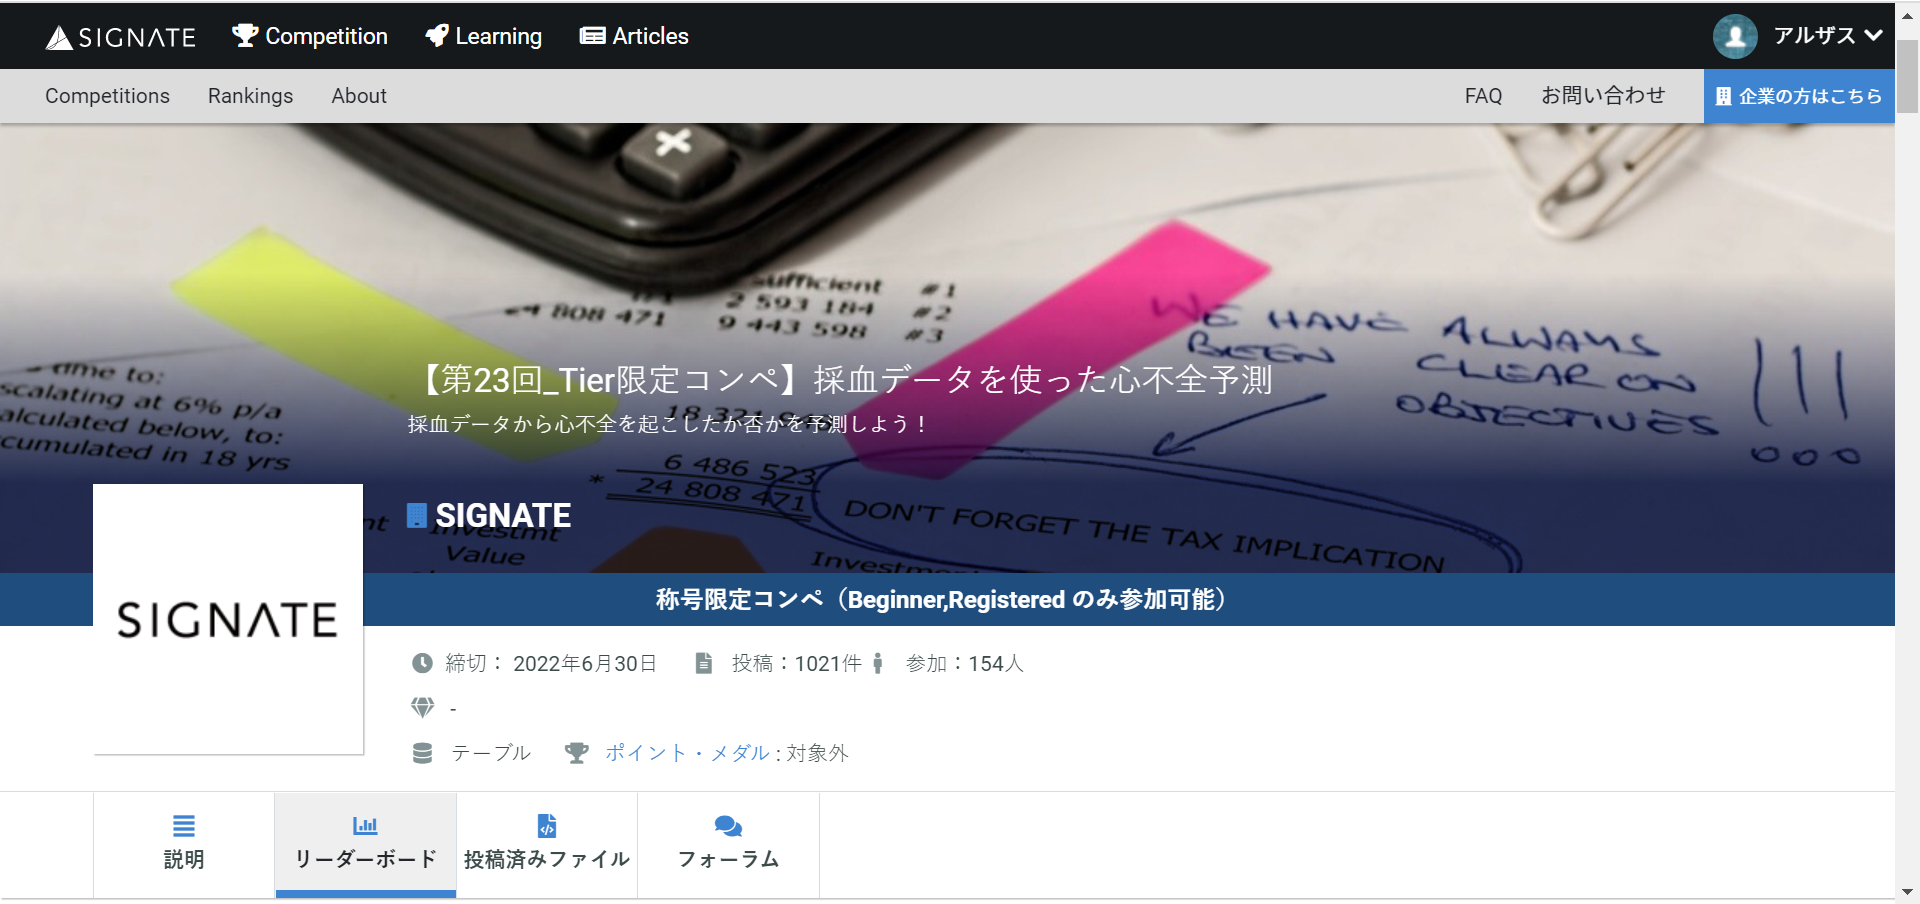

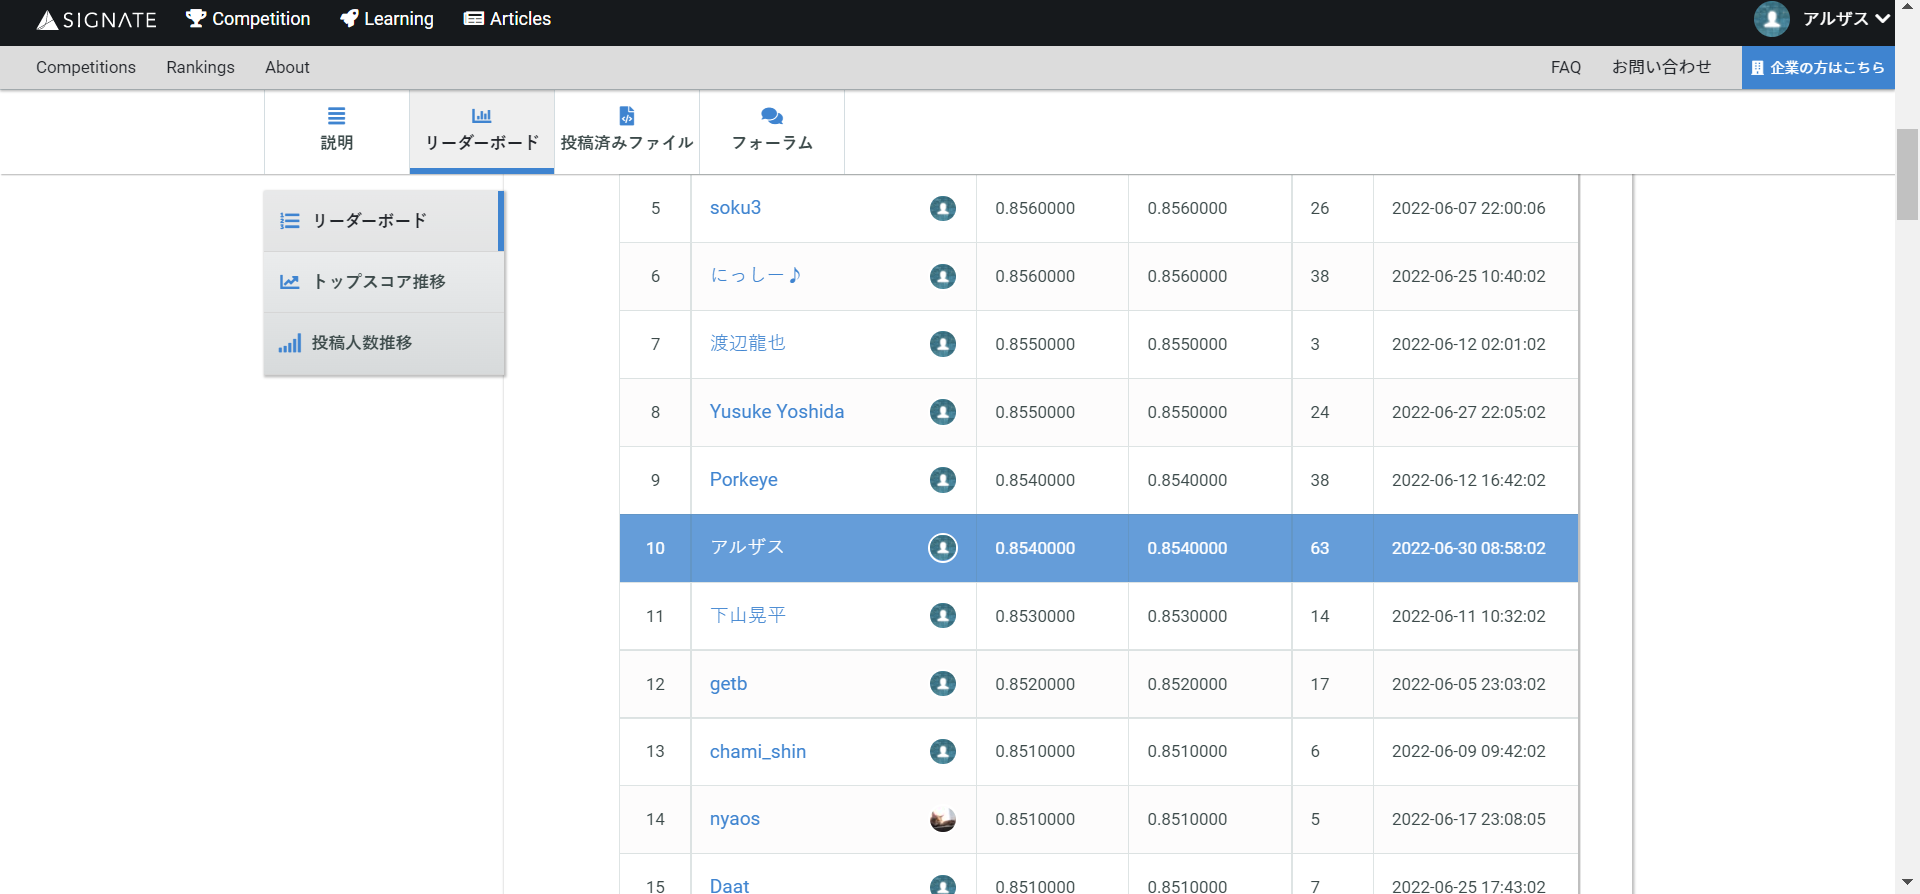

分析方法を簡易的に述べると、主に3つの段階から成る。<r>



1. 特徴量を全て標準化し、各データ間で四則演算を取り、新しい特徴量を作った。
2. k分割交差検証を使った、LightGBMでの学習を2回行った。1回目は全ての特徴量を使って学習をした。2回目では、1回目の学習で重要度の高かった特徴量の上位244個のみを使って学習した。
3.2回目の学習で構築したモデルで、予測結果を出力した。









#**Google Driveをマウントしてアクセスできるようにする。**

In [2]:
# Google Colab環境ではGoogle Driveをマウントしてアクセスできるようにする。
import sys

if 'google.colab' in sys.modules:
    # Google Drive をマウントします
    from google.colab import drive
    mount_dir = "/content/drive"
    drive.mount(mount_dir)

Mounted at /content/drive


#**ライブラリのインポート**

In [ ]:
#ライブラリのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()
import warnings # 実行に関係ない警告を無視
warnings.filterwarnings('ignore')

from sklearn import datasets
from sklearn.model_selection import train_test_split # データセット分割用

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix

#LGBのインストール
import lightgbm as lgb
from lightgbm import LGBMModel

In [ ]:
from sklearn.model_selection import KFold
from functools import partial

!pip install git+https://github.com/pfnet-research/xfeat.git

from xfeat import SelectCategorical, LabelEncoder, Pipeline, ConcatCombination, SelectNumerical, \
    ArithmeticCombinations, TargetEncoder, aggregation, GBDTFeatureSelector, GBDTFeatureExplorer



In [ ]:
# モデル評価用
from sklearn.metrics import accuracy_score 
from sklearn.metrics import log_loss 
from sklearn.metrics import roc_auc_score

# データフレームを綺麗に出力する関数
import IPython
def display(*dfs, head=True):
    for df in dfs:
        IPython.display.display(df.head() if head else df)

In [ ]:
#SIGNAGEで配布されたデータを、それぞれインポート
df_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/肺コンペ/train (4).csv")
df_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/肺コンペ/test (4).csv")
df_sample_sub = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/肺コンペ/sample_submission (1).csv", header=None)
df_sample_sub.columns = ["index", 'target']

#**前処理**

In [ ]:
#testデータとtrainデータの結合（操作を同時に行うために）
def merge_train_test(df_train, df_test):
    if 'target' not in list(df_test.columns):
        df_test['target'] = -100
    res = pd.concat([df_train, df_test])
    res.reset_index(inplace=True, drop=True)
    return res

#testデータとtrainデータに分け戻す
def split_train_test(df):
    df_train = df[df['target'] != -100]
    df_test = df[df['target'] == -100]
    df_train.reset_index(inplace=True, drop=True)
    df_test.reset_index(inplace=True, drop=True)
    return df_train, df_test

#testデータとtrainデータの結合して、dfに入れる
df = merge_train_test(df_train, df_test)

In [ ]:
#標準化
for col in[
            'age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time']:
       
       df["standardscaled_" + col] = StandardScaler().fit_transform(df[[col]])[:, 0]

In [ ]:
#過学習を防ぐため、標準化してない元の特徴量を削除する。

df_train = df_train.drop(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time'], axis=1)

df_test = df_test.drop(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time'], axis=1)

In [ ]:
#関係のない"id"の削除
df = df.drop("id", axis=1)

In [ ]:
#特徴量を2種類取り出し、それらの和を新たな特徴量として作成。それを全ての2つの組み合わせで行う。

encoder = Pipeline([
    SelectNumerical(),
    ArithmeticCombinations(
        input_cols=[
       'standardscaled_age', 'standardscaled_anaemia',
       'standardscaled_creatinine_phosphokinase', 'standardscaled_diabetes',
       'standardscaled_ejection_fraction',
       'standardscaled_high_blood_pressure', 'standardscaled_platelets',
       'standardscaled_serum_creatinine', 'standardscaled_serum_sodium',
       'standardscaled_sex', 'standardscaled_smoking', 'standardscaled_time'], 
       output_suffix="_add",
        drop_origin=True, 
        operator="+", 
        r=2,)
    ])

add_encoded_df = encoder.fit_transform(df)
df = pd.concat([df,add_encoded_df], axis = 1)

In [ ]:
#特徴量を2種類取り出し、それらの差を新たな特徴量として作成。それを全ての2つの組み合わせで行う。
encoder = Pipeline([
    SelectNumerical(),
    ArithmeticCombinations(
        input_cols=[
       'standardscaled_age', 'standardscaled_anaemia',
       'standardscaled_creatinine_phosphokinase', 'standardscaled_diabetes',
       'standardscaled_ejection_fraction',
       'standardscaled_high_blood_pressure', 'standardscaled_platelets',
       'standardscaled_serum_creatinine', 'standardscaled_serum_sodium',
       'standardscaled_sex', 'standardscaled_smoking', 'standardscaled_time'], 
        drop_origin=True, 
        output_suffix="_subt",
        operator="-", 
        r=2,)
    ])

subt_encoded_df = encoder.fit_transform(df)
df = pd.concat([df,subt_encoded_df], axis = 1)

In [ ]:
#特徴量を2種類取り出し、それらの積を新たな特徴量として作成。それを全ての2つの組み合わせで行う。
encoder = Pipeline([
    SelectNumerical(),
    ArithmeticCombinations(
        input_cols=[
       'standardscaled_age', 'standardscaled_anaemia',
       'standardscaled_creatinine_phosphokinase', 'standardscaled_diabetes',
       'standardscaled_ejection_fraction',
       'standardscaled_high_blood_pressure', 'standardscaled_platelets',
       'standardscaled_serum_creatinine', 'standardscaled_serum_sodium',
       'standardscaled_sex', 'standardscaled_smoking', 'standardscaled_time'], 
       output_suffix="_multi",
        drop_origin=True, 
        operator="*", 
        r=2,)
    ])

multi_encoded_df = encoder.fit_transform(df)

df = pd.concat([df,multi_encoded_df], axis = 1)

In [ ]:
#特徴量を2種類取り出し、それらの割り算を新たな特徴量として作成。それを全ての2つの組み合わせで行う。
encoder = Pipeline([
    SelectNumerical(),
    ArithmeticCombinations(
        input_cols=[
       'standardscaled_age', 'standardscaled_anaemia',
       'standardscaled_creatinine_phosphokinase', 'standardscaled_diabetes',
       'standardscaled_ejection_fraction',
       'standardscaled_high_blood_pressure', 'standardscaled_platelets',
       'standardscaled_serum_creatinine', 'standardscaled_serum_sodium',
       'standardscaled_sex', 'standardscaled_smoking', 'standardscaled_time'], 
        drop_origin=True, 
        output_suffix="_div",
        operator="/", 
        r=2,)
    ])

div_encoded_df = encoder.fit_transform(df)
div_encoded_df
df = pd.concat([df,div_encoded_df], axis = 1)

In [ ]:
#train,testに分け戻す
df_train, df_test = split_train_test(df)

target = df_train["target"]
df_train = df_train.drop("target", axis =1)


In [ ]:
# parameters

N_CLASSES = 2
n_neighbors = 6
N_SPLITS = 5
SEED_SKF = 42

#**k分割交差検証を使い、LightGBMで学習。**

In [ ]:
#featuresに、trainデータの全ての特徴量を入れる。
features = df_train.columns.tolist()

features_categorical = []

#パラメータのチューニング

lgb_params = {
    "objective": "multiclass",
    "num_class": N_CLASSES,
    "learning_rate": 0.01,
    "num_leaves": 3,
    "n_estimators": 10000,
    "min_data_in_leaf": 40,
    "verbosity": 0,
    "seed": 42,
}

#k分割交差検証を使って、LightGBMで学習
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED_SKF)
oof = np.zeros((len(df_train), N_CLASSES))
predictions = np.zeros((len(df_test), N_CLASSES))

df_feature_importance = pd.DataFrame()

for fold_, (indexes_trn, indexes_val) in enumerate(skf.split(df_train.values, target.values)):
   

    print(f"------------------------------ fold {fold_} ------------------------------")
    df_trn = df_train.loc[indexes_trn].reset_index(drop=True)
    df_val = df_train.loc[indexes_val].reset_index(drop=True)

    target_trn = target.loc[indexes_trn].reset_index(drop=True)
    target_val = target.loc[indexes_val].reset_index(drop=True)

    lgb_train = lgb.Dataset(
            df_trn.loc[:, features],
          label=target_trn,
          categorical_feature=features_categorical
      )
    lgb_valid = lgb.Dataset(
          df_val.loc[:, features],
          label=target_val,
          categorical_feature=features_categorical
      )

    num_round = 999999999

    model = lgb.train(
          lgb_params,
          lgb_train, 
          valid_sets=[lgb_train, lgb_valid], 
          verbose_eval=500,
          early_stopping_rounds=300 if num_round >= 1e8 else None,
          fobj=None
      )
      
    
    prediction_round = model.best_iteration+150 if num_round >= 1e8 else num_round
    oof[indexes_val] = model.predict(df_val[features], num_iteration=prediction_round)
      
    #特徴量のimportanceを表示 
    df_fold_importance = pd.DataFrame()
    df_fold_importance["feature"] = features
    df_fold_importance["importance"] = model.feature_importance()
    df_fold_importance["fold"] = fold_
    df_feature_importance = pd.concat([df_feature_importance, df_fold_importance], axis=0)
      
      
    #平均を、予測結果にいれる
    predictions += model.predict(df_test[features], num_iteration=prediction_round) / N_SPLITS
    print()

#一番確信度が高いラベルを、予測結果として採用。
df_test["prediction"] = predictions.argmax(1)

print()
print(classification_report(target, oof.argmax(1), digits=4))

print(accuracy_score(target, oof.argmax(1)))

print(df_feature_importance.sort_values(by="importance", ascending=False))

layer2_train_pred, layer2_test_pred = oof, predictions

In [ ]:
#特徴量を、importance純に並び替える
impo= df_feature_importance.sort_values(by="importance", ascending=False)

In [ ]:
#importance順で上から244個の特徴量だけ残す。
impo= df_feature_importance.sort_values(by="importance", ascending=False)
importance_top = impo[:244].feature.tolist()

features = importance_top

#残ったimportanceで、もう一度学習し直す。

features_categorical = []


#パラメータのチューニング
lgb_params = {
    "objective": "multiclass",
    "num_class": N_CLASSES,
    "learning_rate": 0.01,
    "num_leaves": 3,
    "n_estimators": 10000,
    "min_data_in_leaf": 40,
    "verbosity": 0,
    "seed": 42,
}

#k分割交差検証を使って、LightGBMで学習
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED_SKF)
oof = np.zeros((len(df_train), N_CLASSES))
predictions = np.zeros((len(df_test), N_CLASSES))

df_feature_importance = pd.DataFrame()

for fold_, (indexes_trn, indexes_val) in enumerate(skf.split(df_train.values, target.values)):
   

    print(f"------------------------------ fold {fold_} ------------------------------")
    df_trn = df_train.loc[indexes_trn].reset_index(drop=True)
    df_val = df_train.loc[indexes_val].reset_index(drop=True)

    target_trn = target.loc[indexes_trn].reset_index(drop=True)
    target_val = target.loc[indexes_val].reset_index(drop=True)

    lgb_train = lgb.Dataset(
            df_trn.loc[:, features],
          label=target_trn,
          categorical_feature=features_categorical
      )
    lgb_valid = lgb.Dataset(
          df_val.loc[:, features],
          label=target_val,
          categorical_feature=features_categorical
      )

    num_round = 999999999

    model = lgb.train(
          lgb_params,
          lgb_train, 
          valid_sets=[lgb_train, lgb_valid], 
          verbose_eval=500,
          early_stopping_rounds=300 if num_round >= 1e8 else None,
          fobj=None
      )
      
    prediction_round = model.best_iteration+150 if num_round >= 1e8 else num_round
    oof[indexes_val] = model.predict(df_val[features], num_iteration=prediction_round)
      
    #特徴量の重要度を設定
    df_fold_importance = pd.DataFrame()
    df_fold_importance["feature"] = features
    df_fold_importance["importance"] = model.feature_importance()
    df_fold_importance["fold"] = fold_
    df_feature_importance = pd.concat([df_feature_importance, df_fold_importance], axis=0)
      

      
    #平均を、予測結果にいれる
    predictions += model.predict(df_test[features], num_iteration=prediction_round) / N_SPLITS
    print()

#一番確信度が高いラベルを予測結果として採用。
df_test["prediction"] = predictions.argmax(1)

print()
print(classification_report(target, oof.argmax(1), digits=4))

print(accuracy_score(target, oof.argmax(1)))

print(df_feature_importance.sort_values(by="importance", ascending=False))


layer2_train_pred, layer2_test_pred = oof, predictions

#**予測結果を提出ファイルに入れ、csvファイルとして出力。**

In [ ]:
df_test["prediction"] = layer2_test_pred.argmax(1)
df_submission = df_sample_sub.copy()

In [ ]:
df_submission['target'] = df_test["prediction"]

assert not df_submission['target'].isna().any()

In [ ]:
#提出ファイルをCSVとして出力
df_submission.to_csv("submission.csv", header=None, index=False)